In [1]:
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input,concatenate,LSTM,SimpleRNN,Dropout,Embedding,GRU,Bidirectional,Conv1D,MaxPooling1D
from keras.layers.core import Reshape,Flatten
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from kaggle_datasets import KaggleDatasets
from keras import regularizers
import transformers
import traitlets
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split

warnings.simplefilter("ignore")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [2]:
train = pd.read_csv('../input/quora-record-linkage/quora_train.csv',index_col=0,usecols=[1,2,3,4,5,6]).dropna()
test_data = pd.read_csv('../input/quora-record-linkage/quora_test.csv',index_col=0,usecols=[1,2,3,4,5,6]).dropna()

In [3]:
seed = 7
np.random.seed(seed)
X = train.iloc[:,2:4]
Y = train.iloc[:,4]
train_data, val_data, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_test = test_data.iloc[:,2:4]
y_test = test_data.iloc[:,4]

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [5]:
NUM_WORDS=30522
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)
tokenizer.fit_on_texts(train_data.question1+' '+train_data.question2)
sequences1_train = tokenizer.texts_to_sequences(train_data.question1)
sequences2_train = tokenizer.texts_to_sequences(train_data.question2)
sequences1_valid=tokenizer.texts_to_sequences(val_data.question1)
sequences2_valid=tokenizer.texts_to_sequences(val_data.question2)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 72738 unique tokens.


In [6]:
X1_train = pad_sequences(sequences1_train,maxlen=32)
X2_train = pad_sequences(sequences2_train,maxlen=32)
X1_val = pad_sequences(sequences1_valid,maxlen=32)
X2_val = pad_sequences(sequences2_valid,maxlen=32)
print('Shape of X train and X validation tensor:', X1_train.shape,X1_val.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)

Shape of X train and X validation tensor: (258782, 32) (64696, 32)
Shape of label train and validation tensor: (258782,) (64696,)


In [7]:
def build_lstm_model1(MAX_SEQUENCE_LENGTH=32):
    embedding_layer=Embedding(input_dim=30522,output_dim=64,input_length=MAX_SEQUENCE_LENGTH)
    lstm_layer = LSTM(256, dropout=0.1, recurrent_dropout=0.1)

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = lstm_layer(embedded_sequences_1)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = lstm_layer(embedded_sequences_2)

    merged = concatenate([x1, y1])

    preds = Dense(1, activation='sigmoid')(merged)
    
    model = Model(inputs=[sequence_1_input, sequence_2_input],outputs=preds)
    adam = Adam(lr=1e-3)
    model.compile(loss='binary_crossentropy',
        optimizer=adam,
        metrics=[tf.keras.metrics.AUC()])
    return model

In [8]:
def build_lstm_model2(MAX_SEQUENCE_LENGTH=32):
    embedding_layer=Embedding(input_dim=30522,output_dim=64,input_length=MAX_SEQUENCE_LENGTH)
    lstm_layer = LSTM(256, dropout=0.1, recurrent_dropout=0.1)

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = lstm_layer(embedded_sequences_1)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = lstm_layer(embedded_sequences_2)

    merged = concatenate([x1, y1])
    merged = Dropout(0.1)(merged)
    merged = BatchNormalization()(merged)
    preds = Dense(1, activation='sigmoid')(merged)
    
    model = Model(inputs=[sequence_1_input, sequence_2_input],outputs=preds)
    adam = Adam(lr=1e-3)
    model.compile(loss='binary_crossentropy',
        optimizer=adam,
        metrics=[tf.keras.metrics.AUC()])
    return model

In [9]:
def build_lstm_model3(MAX_SEQUENCE_LENGTH=32):
    embedding_layer=Embedding(input_dim=30522,output_dim=64,input_length=MAX_SEQUENCE_LENGTH)
    lstm_layer = LSTM(256, dropout=0.1, recurrent_dropout=0.1)

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = lstm_layer(embedded_sequences_1)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = lstm_layer(embedded_sequences_2)

    merged = concatenate([x1, y1])
    merged = Dropout(0.1)(merged)
    merged = BatchNormalization()(merged)

    merged = Dense(128, activation='relu')(merged)
    merged = Dropout(0.1)(merged)
    merged = BatchNormalization()(merged)

    preds = Dense(1, activation='sigmoid')(merged)
    
    model = Model(inputs=[sequence_1_input, sequence_2_input],outputs=preds)
    adam = Adam(lr=1e-3)
    model.compile(loss='binary_crossentropy',
        optimizer=adam,
        metrics=[tf.keras.metrics.AUC()])
    return model

In [10]:
def build_gru_model1(MAX_SEQUENCE_LENGTH=32):
    embedding_layer=Embedding(input_dim=30522,output_dim=64,input_length=MAX_SEQUENCE_LENGTH)
    gru_layer = GRU(256, dropout=0.1, recurrent_dropout=0.1)

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = gru_layer(embedded_sequences_1)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = gru_layer(embedded_sequences_2)

    merged = concatenate([x1, y1])

    preds = Dense(1, activation='sigmoid')(merged)
    
    model = Model(inputs=[sequence_1_input, sequence_2_input],outputs=preds)
    adam = Adam(lr=1e-3)
    model.compile(loss='binary_crossentropy',
        optimizer=adam,
        metrics=[tf.keras.metrics.AUC()])
    return model

In [11]:
def build_gru_model2(MAX_SEQUENCE_LENGTH=32):
    embedding_layer=Embedding(input_dim=30522,output_dim=64,input_length=MAX_SEQUENCE_LENGTH)
    gru_layer = GRU(256, dropout=0.1, recurrent_dropout=0.1)

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = gru_layer(embedded_sequences_1)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = gru_layer(embedded_sequences_2)

    merged = concatenate([x1, y1])
    merged = Dropout(0.1)(merged)
    merged = BatchNormalization()(merged)

    merged = Dense(128, activation='relu')(merged)
    merged = Dropout(0.1)(merged)
    merged = BatchNormalization()(merged)

    preds = Dense(1, activation='sigmoid')(merged)
    
    model = Model(inputs=[sequence_1_input, sequence_2_input],outputs=preds)
    adam = Adam(lr=1e-3)
    model.compile(loss='binary_crossentropy',
        optimizer=adam,
        metrics=[tf.keras.metrics.AUC()])
    return model

In [12]:
def build_bilstm_model1(MAX_SEQUENCE_LENGTH=32):
    embedding_layer=Embedding(input_dim=30522,output_dim=64,input_length=MAX_SEQUENCE_LENGTH)
    bilstm_layer = Bidirectional(LSTM(256, dropout=0.1, recurrent_dropout=0.1))

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = bilstm_layer(embedded_sequences_1)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = bilstm_layer(embedded_sequences_2)

    merged = concatenate([x1, y1])

    preds = Dense(1, activation='sigmoid')(merged)
    
    model = Model(inputs=[sequence_1_input, sequence_2_input],outputs=preds)
    adam = Adam(lr=1e-3)
    model.compile(loss='binary_crossentropy',
        optimizer=adam,
        metrics=[tf.keras.metrics.AUC()])
    return model

In [13]:
def build_bilstm_model2(MAX_SEQUENCE_LENGTH=32):
    embedding_layer=Embedding(input_dim=30522,output_dim=64,input_length=MAX_SEQUENCE_LENGTH)
    bilstm_layer = Bidirectional(LSTM(256, dropout=0.1, recurrent_dropout=0.1))

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = bilstm_layer(embedded_sequences_1)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = bilstm_layer(embedded_sequences_2)

    merged = concatenate([x1, y1])
    merged = Dropout(0.1)(merged)
    merged = BatchNormalization()(merged)

    merged = Dense(128, activation='relu')(merged)
    merged = Dropout(0.1)(merged)
    merged = BatchNormalization()(merged)

    preds = Dense(1, activation='sigmoid')(merged)
    
    model = Model(inputs=[sequence_1_input, sequence_2_input],outputs=preds)
    adam = Adam(lr=1e-3)
    model.compile(loss='binary_crossentropy',
        optimizer=adam,
        metrics=[tf.keras.metrics.AUC()])
    return model

In [14]:
def build_lstm_model4(MAX_SEQUENCE_LENGTH=32):
    embedding_layer=Embedding(input_dim=30522,output_dim=64,input_length=MAX_SEQUENCE_LENGTH)
    lstm_layer1 = LSTM(256, return_sequences=True,dropout=0.1, recurrent_dropout=0.1)
    lstm_layer2 = LSTM(256, dropout=0.1, recurrent_dropout=0.1)

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = lstm_layer1(embedded_sequences_1)
    x1 = lstm_layer2(x1)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = lstm_layer1(embedded_sequences_2)
    y1= lstm_layer2(y1)

    merged = concatenate([x1, y1])
    merged = Dropout(0.1)(merged)
    merged = BatchNormalization()(merged)

    merged = Dense(128, activation='relu')(merged)
    merged = Dropout(0.1)(merged)
    merged = BatchNormalization()(merged)

    preds = Dense(1, activation='sigmoid')(merged)
    
    model = Model(inputs=[sequence_1_input, sequence_2_input],outputs=preds)
    adam = Adam(lr=1e-3)
    model.compile(loss='binary_crossentropy',
        optimizer=adam,
        metrics=[tf.keras.metrics.AUC()])
    return model

In [15]:
def build_lstm_model5(MAX_SEQUENCE_LENGTH=32):
    embedding_layer=Embedding(input_dim=30522,output_dim=64,input_length=MAX_SEQUENCE_LENGTH)
    conv_layer = Conv2D(100, (3,64),activation='relu',kernel_regularizer=regularizers.l2(0.01))
    #maxpool=MaxPooling2D((MAX_SEQUENCE_LENGTH- 3 + 1,1), strides=(1,1))
    lstm_layer = LSTM(256, dropout=0.1, recurrent_dropout=0.1)

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = Reshape((MAX_SEQUENCE_LENGTH,64,1))(embedded_sequences_1 )
    x1 = conv_layer(x1)
   # x1=maxpool(x1)
    x1=Reshape((30,100))(x1)
    x1 = lstm_layer(x1)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1=Reshape((MAX_SEQUENCE_LENGTH,64,1))(embedded_sequences_2)
    y1 = conv_layer(y1)
 #   y1=maxpool(y1)
    y1=Reshape((30,100))(y1)
    y1 = lstm_layer(y1)

    merged = concatenate([x1, y1])
    merged = Dropout(0.1)(merged)
    merged = BatchNormalization()(merged)

    merged = Dense(128, activation='relu')(merged)
    merged = Dropout(0.1)(merged)
    merged = BatchNormalization()(merged)

    preds = Dense(1, activation='sigmoid')(merged)
    
    model = Model(inputs=[sequence_1_input, sequence_2_input],outputs=preds)
    adam = Adam(lr=1e-3)
    model.compile(loss='binary_crossentropy',
        optimizer=adam,
        metrics=[tf.keras.metrics.AUC()])
    return model

In [27]:
def build_lstm_model6(MAX_SEQUENCE_LENGTH=32):
    embedding_layer=Embedding(input_dim=30522,output_dim=64,input_length=MAX_SEQUENCE_LENGTH)
    lstm_layer = LSTM(256, dropout=0.1, recurrent_dropout=0.1)

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = lstm_layer(embedded_sequences_1)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = lstm_layer(embedded_sequences_2)

    merged = concatenate([x1, y1])
    merged = Dropout(0.1)(merged)
    merged = BatchNormalization()(merged)

    merged = Dense(256, activation='relu')(merged)
    merged = Dropout(0.1)(merged)
    merged = BatchNormalization()(merged)
    
    merged = Dense(128, activation='relu')(merged)
    merged = Dropout(0.1)(merged)
    merged = BatchNormalization()(merged)

    preds = Dense(1, activation='sigmoid', kernel_regularizer='l2')(merged)
    
    model = Model(inputs=[sequence_1_input, sequence_2_input],outputs=preds)
    adam = Adam(lr=1e-3)
    model.compile(loss='binary_crossentropy',
        optimizer=adam,
        metrics=[tf.keras.metrics.AUC()])
    return model

In [28]:
model=build_lstm_model6()
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 32, 64)       1953408     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 256)          328704      embedding_2[0][0]     

In [29]:
callbacks=[EarlyStopping(monitor='val_loss')]
model.fit([X1_train,X2_train], y_train, batch_size=1000, epochs=5, verbose=1, validation_data=([X1_val,X2_val],y_val),callbacks=callbacks)

Epoch 1/5
259/259 [==============================] - 78s 302ms/step - loss: 0.5278 - auc_2: 0.8000 - val_loss: 0.6344 - val_auc_2: 0.8026
Epoch 2/5
259/259 [==============================] - 79s 304ms/step - loss: 0.4014 - auc_2: 0.8931 - val_loss: 0.4996 - val_auc_2: 0.8714
Epoch 3/5
259/259 [==============================] - 79s 304ms/step - loss: 0.3280 - auc_2: 0.9308 - val_loss: 0.6451 - val_auc_2: 0.8724


In [19]:
sequences1_test=tokenizer.texts_to_sequences(test_data.question1)
sequences2_test=tokenizer.texts_to_sequences(test_data.question2.astype(str))
X1_test = pad_sequences(sequences1_test,maxlen=X1_train.shape[1])
X2_test = pad_sequences(sequences2_test,maxlen=X1_train.shape[1])
y_test=test_data.is_duplicate.values

In [20]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt

In [26]:
model.evaluate([X1_test,X2_test],y_test)

2528/2528 [==============================] - 69s 27ms/step - loss: 0.4335 - auc_1: 0.8888


[0.43349167704582214, 0.8888189792633057]

Text(0.5, 1.0, 'Precision-Recall curve: AP=0.82')

<Figure size 432x288 with 0 Axes>

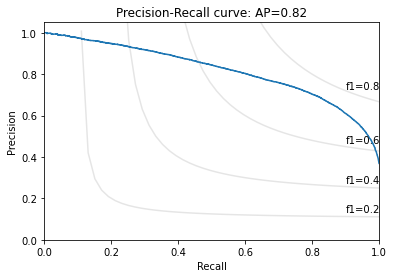

In [22]:
y_score=model.predict([X1_test,X2_test])
precision, recall, f1=precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score,average="micro")

plt.clf()
plt.figure()
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
plt.step(recall,precision,where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Precision-Recall curve: AP={0:0.2f}'
    .format(average_precision))